# Phase 1: Architectural Image Editing - MVP
**SDXL Inpainting + Depth ControlNet**

**Kaggle Setup**: Enable GPU (T4/P100) + Internet ON


In [1]:
# Fix nu

In [2]:

#%pip install -q --upgrade numpy scikit-learn
# Then install diffusers dependencies
#%pip install -q diffusers[torch]>=0.27.0 controlnet_aux opencv-python transformers accelerate

# Restart kernel after installation
#import IPython
#IPython.Application.instance().kernel.do_shutdown(True)
#%pip install huggingface_hub[hf_xet]


In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import torch
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
from controlnet_aux import MidasDetector
from PIL import Image, ImageDraw
import numpy as np

print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

c:\Users\hashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.5.1+cu121
CUDA Available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Load Models (~5 min first time)


In [2]:
# Load ControlNet for Depth
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)

# Load VAE for better quality
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)

# Load SDXL Inpainting Pipeline
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16"
)

# Optimize for Kaggle GPU
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()

print("✅ Models loaded!")


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

✅ Models loaded!


In [3]:
import os
os.makedirs("local_pipe", exist_ok=True)
pipe.save_pretrained("local_pipe")


## Utility Functions


In [6]:
def extract_depth(image):
    """Extract depth map using Midas"""
    depth_estimator = MidasDetector.from_pretrained("lllyasviel/Annotators")
    return depth_estimator(image)

def create_mask_from_bbox(image_size, bbox):
    """Create mask from bounding box [x1, y1, x2, y2]"""
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle(bbox, fill=255)
    return mask

def resize_image(input_image, resolution=1024):
    """Resize while maintaining aspect ratio"""
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H = int(round(H * k / 64.0)) * 64
    W = int(round(W * k / 64.0)) * 64
    return input_image.resize((W, H), resample=Image.LANCZOS)

print("✅ Utilities ready!")


✅ Utilities ready!


## Main Editing Function


In [7]:
def architectural_edit(image_path, prompt, mask_bbox=None, controlnet_scale=0.5, num_steps=30, seed=42):
    """
    Edit architectural image with depth guidance
    Args:
        image_path: URL or path to image
        prompt: Edit instruction
        mask_bbox: [x1,y1,x2,y2] or None for full image
        controlnet_scale: Depth guidance strength (0-1)
    """
    # Load and resize
    init_image = load_image(image_path)
    init_image = resize_image(init_image, 1024)
    
    # Create mask
    if mask_bbox is None:
        mask = Image.new('L', init_image.size, 255)
    else:
        mask = create_mask_from_bbox(init_image.size, mask_bbox)
    
    # Extract depth and resize to match image
    print("Extracting depth...")
    depth_map = extract_depth(init_image)
    depth_map = depth_map.resize(init_image.size, resample=Image.LANCZOS)  # FIX: Ensure same size
    
    # Generate
    print(f"Generating: '{prompt}'")
    generator = torch.Generator(device="cuda").manual_seed(seed)
    
    result = pipe(
        prompt=prompt,
        negative_prompt="blurry, distorted, low quality",
        image=init_image,
        mask_image=mask,
        control_image=depth_map,
        controlnet_conditioning_scale=controlnet_scale,
        guidance_scale=7.5,
        num_inference_steps=num_steps,
        generator=generator,
        strength=1.0
    ).images[0]
    
    return result, init_image, mask, depth_map

print("✅ Pipeline ready!")

✅ Pipeline ready!


## Run Editing


In [8]:
# Cell 10 - Change these values
IMAGE_PATH = "https://images.unsplash.com/photo-1486718448742-163732cd1544?w=800"
PROMPT = "white concrete brutalist facade with minimal windows, architectural photography"

edited, original, mask, depth = architectural_edit(
    image_path=IMAGE_PATH,
    prompt=PROMPT,
    controlnet_scale=0.6,  # Higher for more geometric accuracy
    num_steps=40
)

Extracting depth...
Generating: 'white concrete brutalist facade with minimal windows, architectural photography'
Generating: 'white concrete brutalist facade with minimal windows, architectural photography'


100%|██████████| 40/40 [27:40<00:00, 41.51s/it]



## Visualize Results


=== ORIGINAL ===


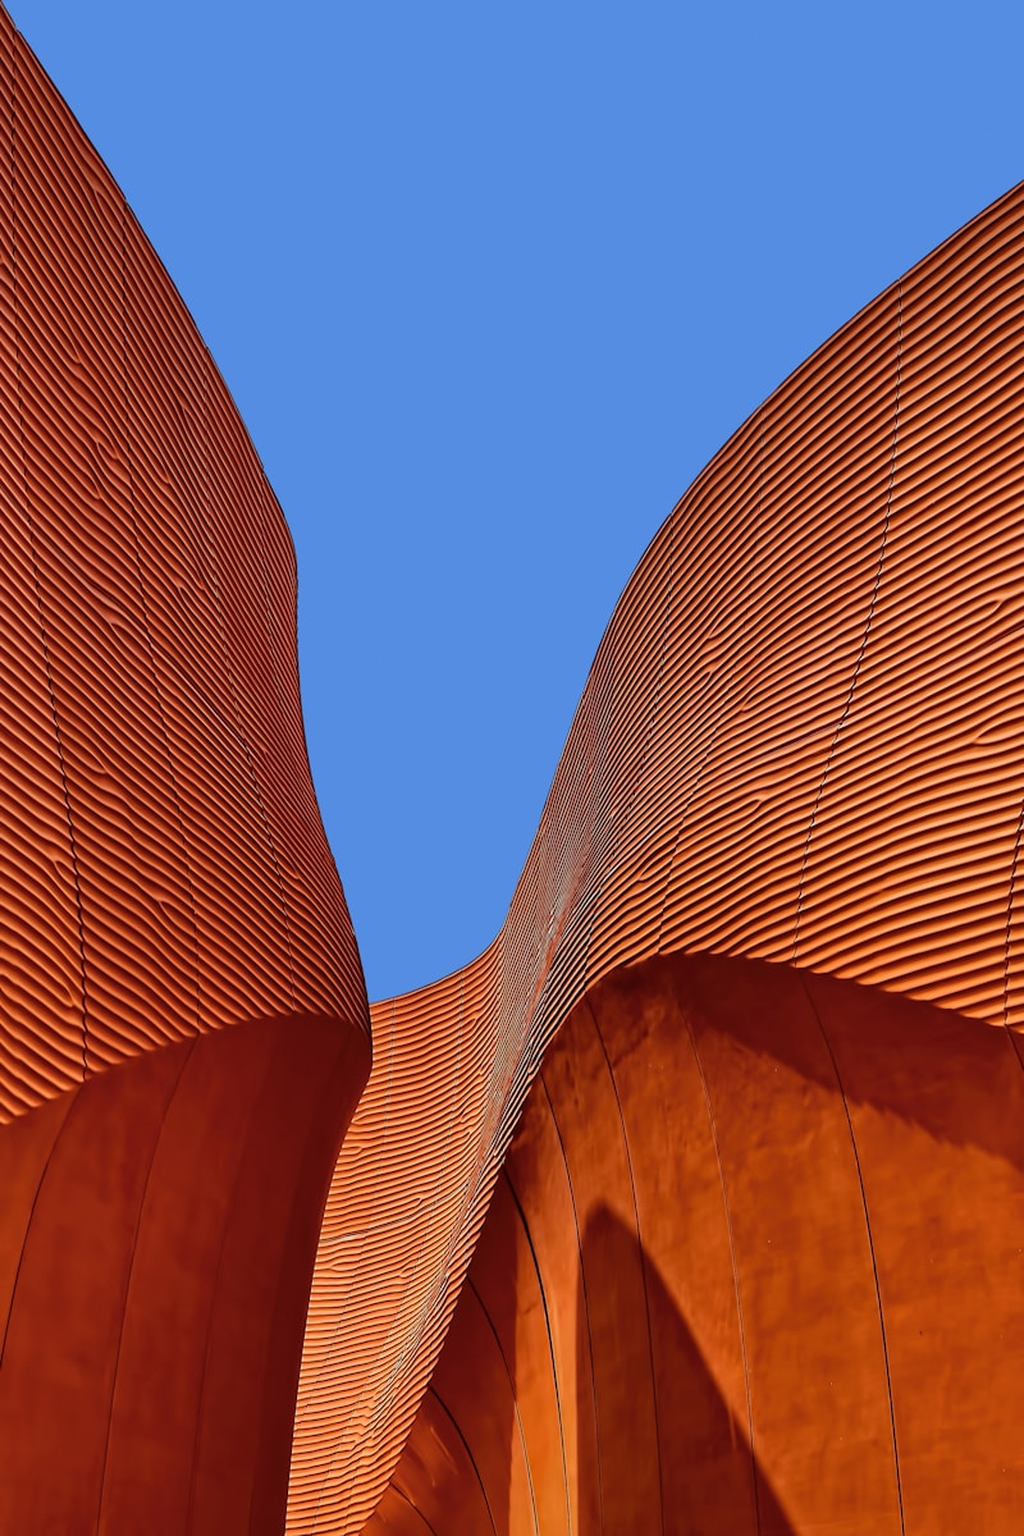


=== MASK ===


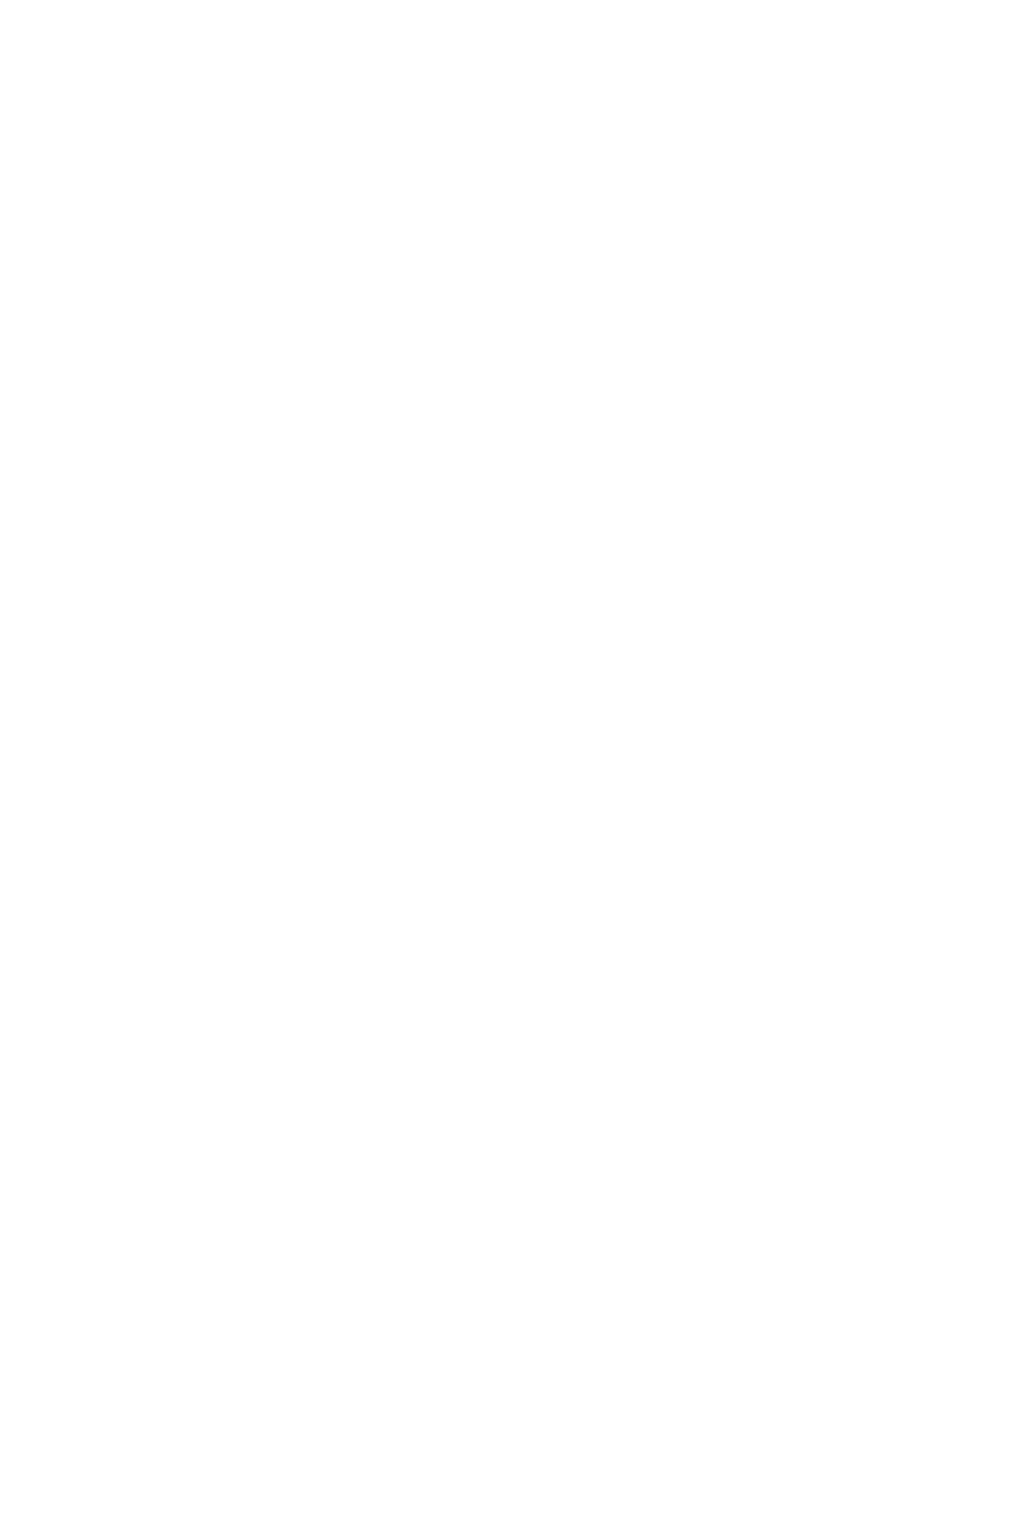


=== DEPTH MAP ===


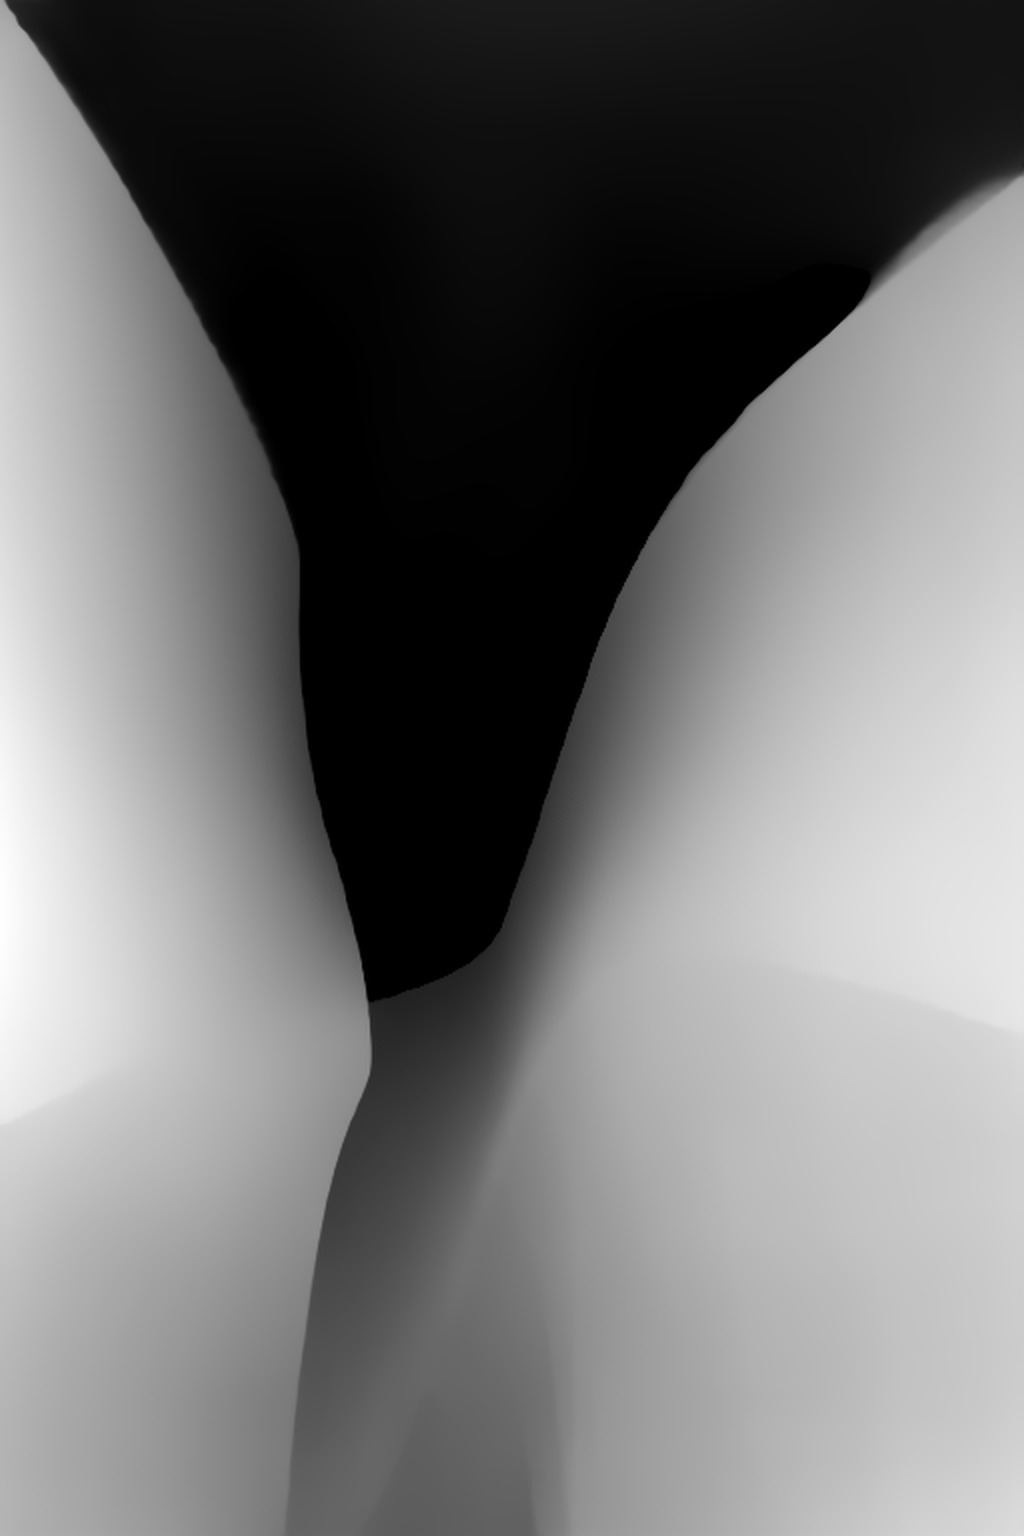


=== EDITED RESULT ===


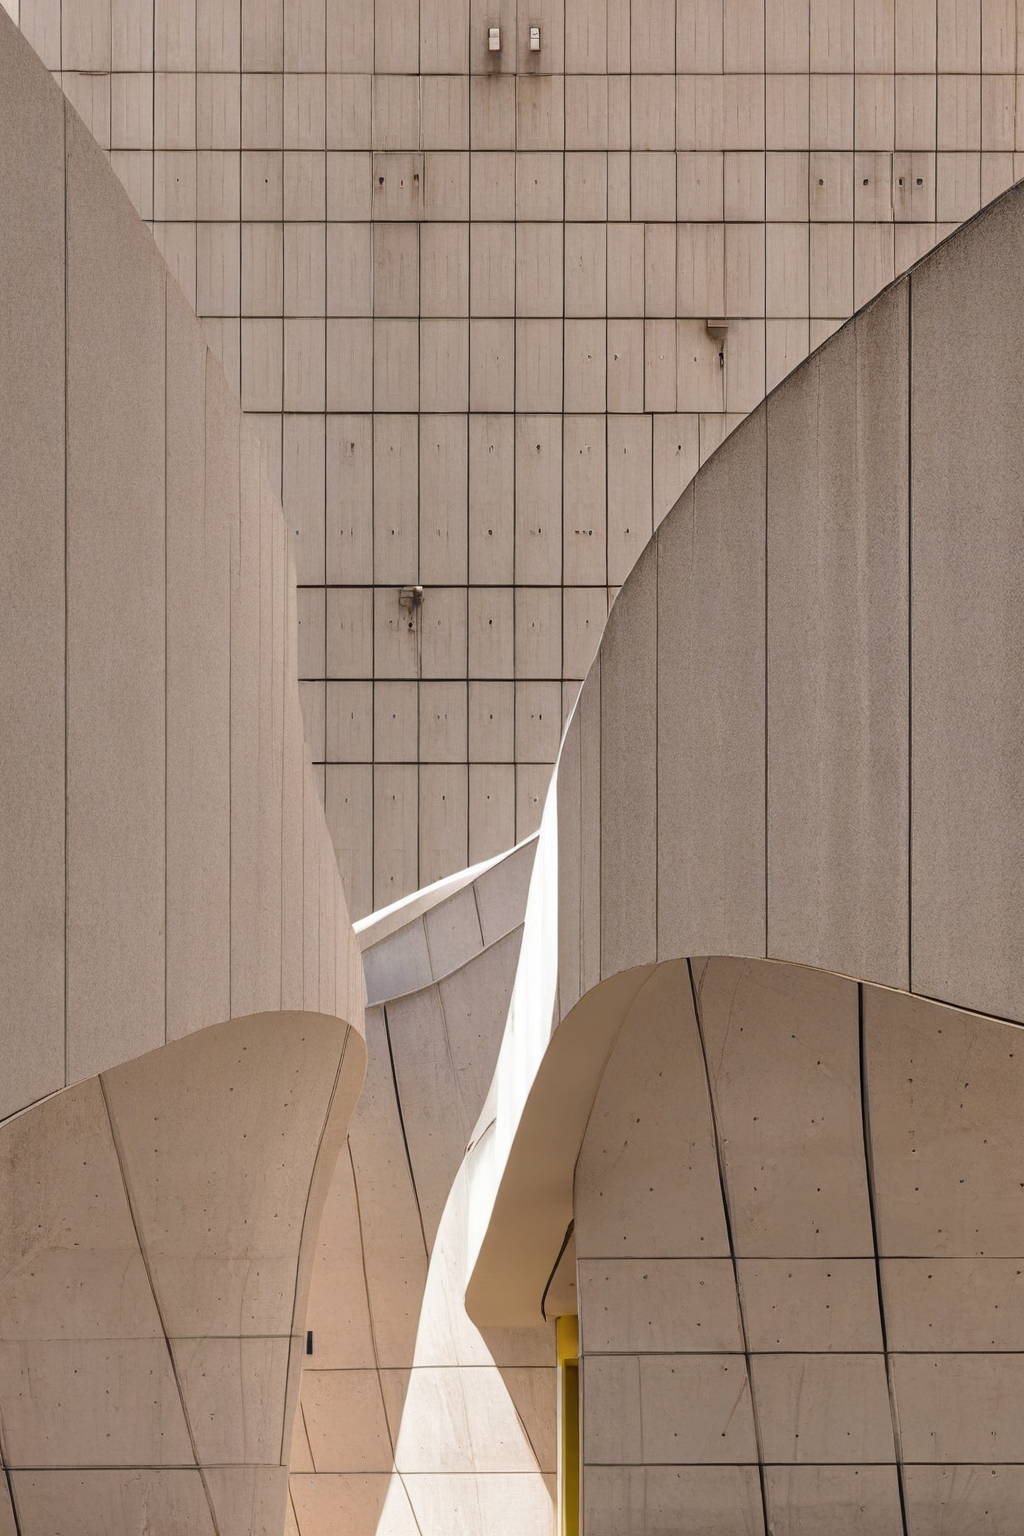

✅ Saved to result.png


In [9]:
# Simple visualization without matplotlib
from IPython.display import display

print("=== ORIGINAL ===")
display(original)

print("\n=== MASK ===")
display(mask)

print("\n=== DEPTH MAP ===")
display(depth)

print("\n=== EDITED RESULT ===")
display(edited)

edited.save("result.png")
print("✅ Saved to result.png")

## Next Steps

**Phase 2**: Add MLSD line detection for better geometry preservation
**Phase 3**: Add CLIPSeg/Grounded-SAM for automatic masking from text prompts

**Tips**:
- Adjust `controlnet_scale` (0.3-0.7) to balance depth vs creativity
- Use specific prompts: "red brick facade", "glass curtain wall", etc.
- For masked edits: use [x1, y1, x2, y2] coordinates
